# Проект 'Прогнозирование количества заказов такси'

## Подготовка

### Импорт библиотек

Установим дополнительные пакеты:

In [1]:
!pip install catboost
!pip install lightgbm
!pip install statsmodels

Импортируем всё, что нам понадобится:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

### Общая информация о датасете

Датасет представляет из себя набор чисел, обозначающих число заказов такси в конкретный момент времени. Другими словами, это временной ряд с интервалом в 10 минут. \
Так как мы изначально обладаем этой информацией, выполним загрузку датасета, указав нужный тип для столбца времени (**datetime64[ns]**) и сделав его индексом.

In [3]:
try:
    data = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

Выведем общую информацию, чтобы убедиться в корректности действий:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Первые 5 строчек датасета:

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Действительно, теперь мы видим, что количество заказов находится в столбце 'num_orders', а индексы обозначают моменты времени с 00:00 1 марта 2018 года до 23:50 31 августа 2018 года. \
Однако далеко не факт, что все строки расположены в хронологическом порядке. Проверим это:

In [6]:
print(data.index.is_monotonic_increasing)

True


В случае False мы бы запросто всё исправили, но этого делать не придётся. \
Построим график нашего временного ряда.

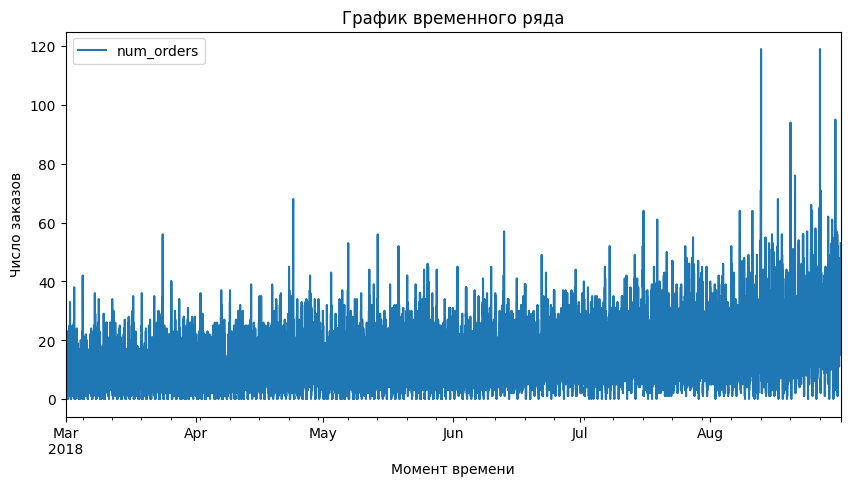

In [7]:
data.plot(title='График временного ряда', xlabel='Момент времени', ylabel='Число заказов', figsize=(10, 5));

Ничего не понятно! Это вполне естсетвенно, ведь измерения проводились каждые 10 минут. Для привлечения водителей в район аэропорта нам необходимо знать число заказов в течение следующего часа. Поэтому нам нужно сделать ресемплирование (изменение интервала) временного ряда. \
Для этого выполним следующие вещи:
- Установим длину интервала в 1 час 
- Для каждой группы посчитаем сумму заказов

Затем нарисуем график.

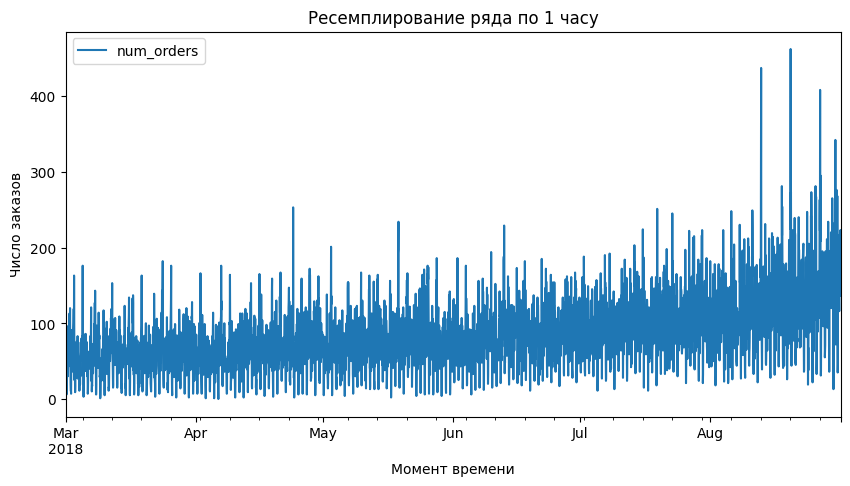

In [8]:
data = data.resample('1H').sum()
data.plot(figsize=(10, 5), title='Ресемплирование ряда по 1 часу', xlabel='Момент времени', ylabel='Число заказов');

С марта по конец августа проходит более 4000 часов. Такое количество значений трудно детально отобразить. Поэтому в качестве примера взглянем на заказы только за март:

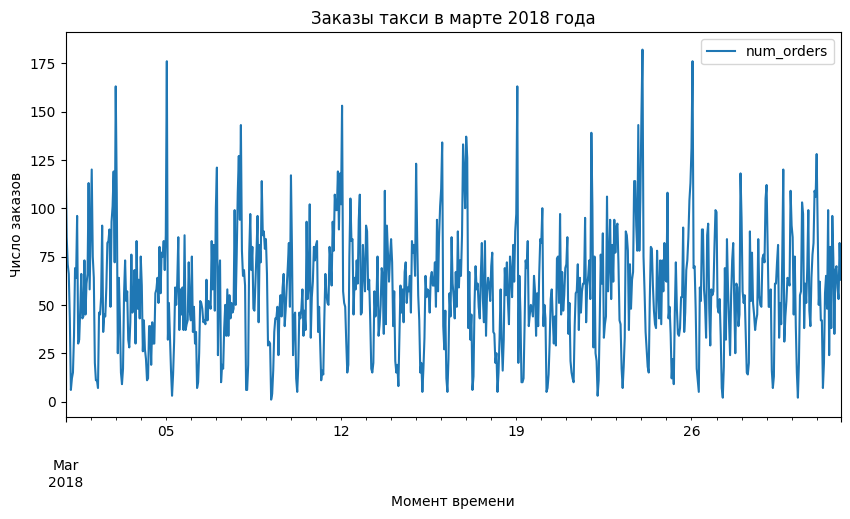

In [9]:
data['2018-03-01':'2018-03-31'].plot(figsize=(10, 5), title='Заказы такси в марте 2018 года', 
                                     xlabel='Момент времени', ylabel='Число заказов');

### Вывод
Мы загрузили данные предварительно обработав их как временной ряд. После ресемплироваания по 1 часу в датасете указано более 4000 значений о количестве заказов такси.

Перейдём к следующему разделу.

## Анализ

Проанализиурем наш временной ряд, а именно: вычислим **скользящее среднее**; разложим на **тренды**, **сезонность** и **остаток**; покажем **разности**.

### Скользящее среднее

По предыдущим графикам видно, что у временного ряда довольно сильные колебания. Для такси это вполне характерно: ночью заказов мало, в час пик - много. \
С помощью скользящего среднего попробуем сгладить эти колебания.

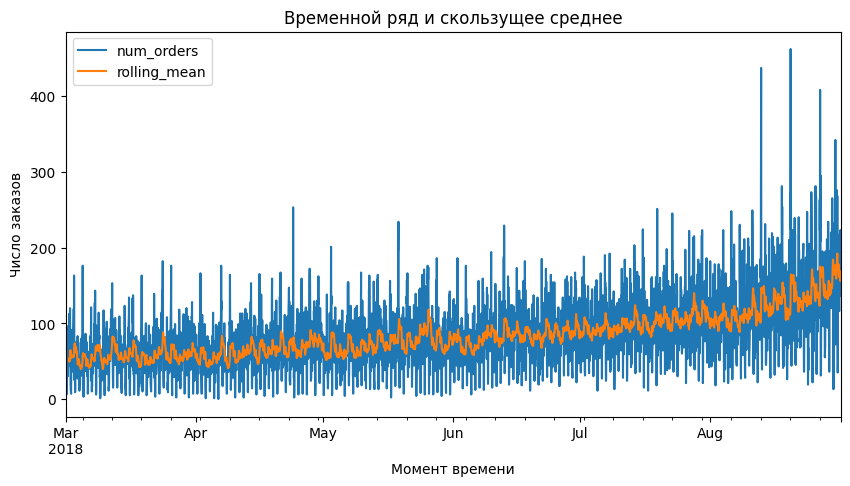

In [10]:
data['rolling_mean'] = data.rolling(20).mean()
data.plot(figsize=(10, 5), title='Временной ряд и скользущее среднее', xlabel='Момент времени', ylabel='Число заказов');

С размером окна (интервала усреднения) можно поэксперементировать, но при **20** график имеет наиболее похожий на исходные данные вид, но выбросов в нём уже гораздо меньше. Также можно заметить, что в течение августа заказов становится гораздо больше, но об этом далее. 

### Тренды и сезонность

Чтобы лучше понимать временной ряд, разберём его на тренды (плавные изменения среднего значения без повторяющихся закономерностей), сезонность (циклично повторяющиеся закономерности) и остаток (невошедшее в предыдущие 2).

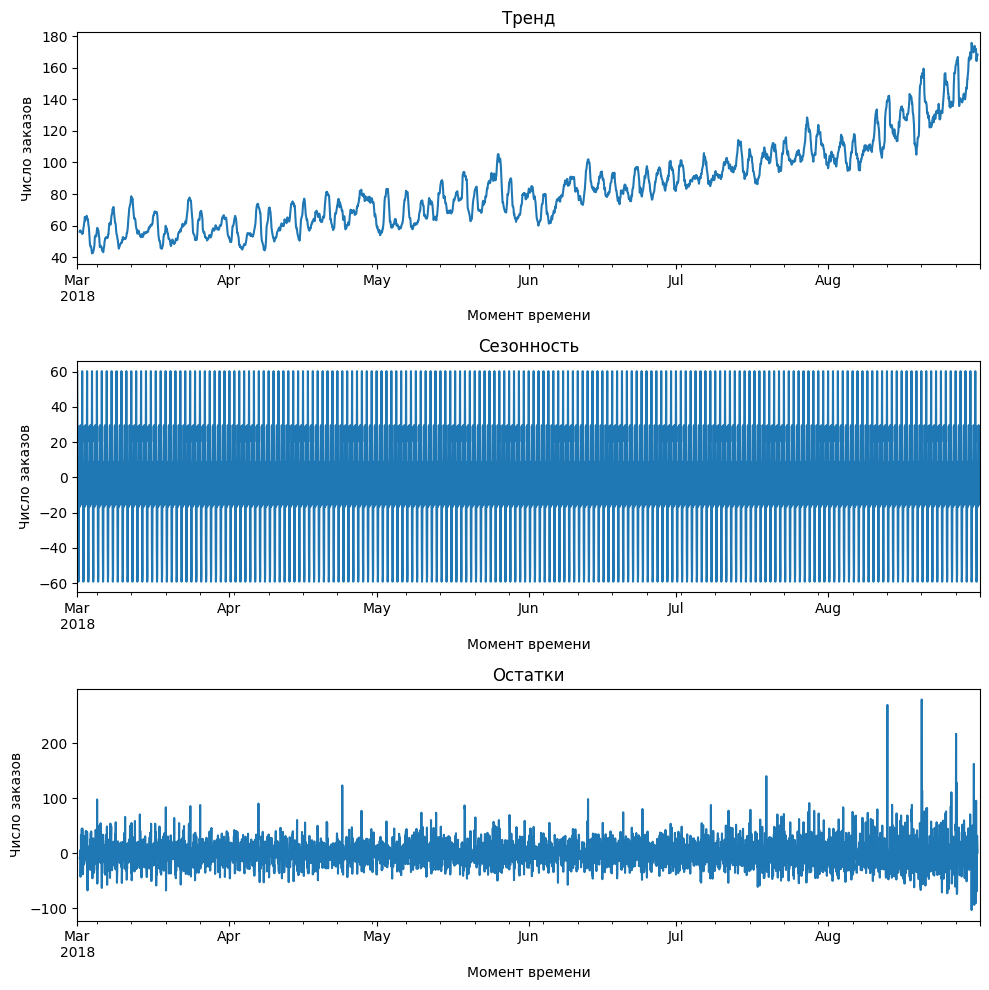

In [11]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(10, 10))

# тренд
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), xlabel='Момент времени', ylabel='Число заказов')
plt.title('Тренд')

# сезонность
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), xlabel='Момент времени', ylabel='Число заказов')
plt.title('Сезонность')

# остаток
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), xlabel='Момент времени', ylabel='Число заказов')
plt.title('Остатки')

plt.tight_layout()
plt.show()

Теперь мы видим тренд на увеличение числа заказов такси с увеличением тмепературы за окном. Сезонность разберём дальше.

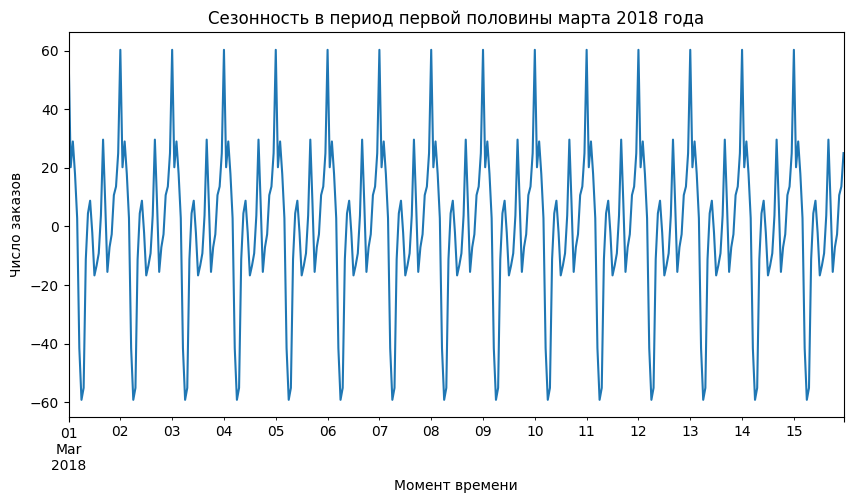

In [12]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(figsize=(10, 5), 
                                                    title='Сезонность в период первой половины марта 2018 года', 
                                                    xlabel='Момент времени', ylabel='Число заказов');

Предположение оказалось верным: в первые часы дня все спят, днём на такси ездят немногие, а вот вечером спрос всегда большой.

### Разности временного ряда

Теперь вычислим разности, их среднее значение и отклонения. Всё это изобразим на графике.

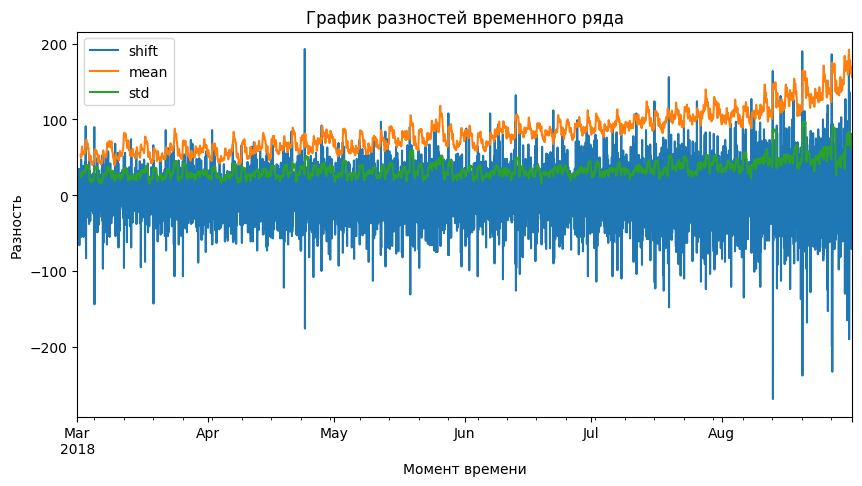

In [13]:
data['shift'] = data['num_orders'] - data['num_orders'].shift()

data['mean'] = data['num_orders'].rolling(20).mean()
data['std'] = data['num_orders'].rolling(20).std()
data.loc[:, 'shift':'std'].plot(figsize=(10, 5), title='График разностей временного ряда', 
                                xlabel='Момент времени', ylabel='Разность');

Так выглядел бы стационарный ряд (среднее и стандартное отклонение почти не меняются).

### Вывод

Мы провели анализ временного ряда числа заказов такси. Показали скользящее среднее; возрастающий тренд и сезонность каждого дня; разности ряда. \
Перейдём к обучению моделей.

## Обучение

### Создание признаков

Очистим данные от признаков, которые мы создали ранее для визуализации: 

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4397 non-null   float64
 2   shift         4415 non-null   float64
 3   mean          4397 non-null   float64
 4   std           4397 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 336.0 KB


In [15]:
remove = data.columns[data.dtypes == float].to_list()
data.drop(remove, axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB


Теперь напишем функцию для создания следующих признаков:
- **Календарные (год, месяц, число, день недели)**. По индексу модель не сможет понять как дата влияет на число заказов, поэтому выпишем их напрямую.
- **«Отстающие значения» (lag features)**. По нескольким предыдущим значениям модель сможет предсказывать рост или уменьшение целевого признака.
- **Скользящее среднее**. Оно покажет общий тренд временного ряда, но необходим сдвиг, чтобы не использовать текущее значение.

У функции будет 2 аргумента: **max_lag** - число предыдущих значений, **rolling_mean_size** - размер окна для вычисления скользящего среднего.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return new_data

Сохраним исходный датасет и протестируем работу функции при маленьких параметрах:

In [17]:
origin_data = data.copy()
data = make_features(origin_data, 4, 4)
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,86.5


А теперь заново, но для большого числа предыдущих значений.

In [38]:
data = make_features(origin_data, 400, 400)

C:\Users\honor\AppData\Local\Temp\ipykernel_16412\656478306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
C:\Users\honor\AppData\Local\Temp\ipykernel_16412\656478306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
C:\Users\honor\AppData\Local\Temp\ipykernel_16412\656478306.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [39]:
data.head(3)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


У первых 400 значений есть не все предыдущие, поэтому удалим их. 

In [20]:
data.isna().sum()

num_orders        0
year              0
month             0
day               0
dayofweek         0
               ... 
lag_397         397
lag_398         398
lag_399         399
lag_400         400
rolling_mean    400
Length: 406, dtype: int64

In [21]:
data.dropna(inplace=True)
data.head(3)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-17 16:00:00,53,2018,3,17,5,82.0,65.0,43.0,49.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,57.2125
2018-03-17 17:00:00,41,2018,3,17,5,53.0,82.0,65.0,43.0,49.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,57.0350
2018-03-17 18:00:00,83,2018,3,17,5,41.0,53.0,82.0,65.0,43.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.9250


In [22]:
data.isna().sum()

num_orders      0
year            0
month           0
day             0
dayofweek       0
               ..
lag_397         0
lag_398         0
lag_399         0
lag_400         0
rolling_mean    0
Length: 406, dtype: int64

In [23]:
data.shape

(4016, 406)

Теперь у нас достаточно признаков для обучения моделей. 

### Разделим данные на выробки

Выделим целевой признак, а затем отведём каждой из выборок следующие доли:
- Обучающая = **0.65** от датасета
- Валидационная = **0.25** от датасета
- Тестовая = **0.1** от датасета

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train, valid = train_test_split(train, shuffle=False, test_size=0.27)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим корректность разделения:

In [25]:
print('Размер обучающей выборки:', len(features_train), 'или', len(features_train) / len(data) * 100, '%')
print('Размер валидационной выборки:', len(features_valid), 'или',len(features_valid) / len(data) * 100, '%')
print('Размер тестовой выборки:', len(features_test), 'или',len(features_test) / len(data) * 100, '%')

Размер обучающей выборки: 2638 или 65.68725099601593 %
Размер валидационной выборки: 976 или 24.302788844621514 %
Размер тестовой выборки: 402 или 10.00996015936255 %


Наконец, обучим модели.

### Линейная регрессия

In [42]:
%%time

linear_model = LinearRegression()

linear_model.fit(features_train, target_train)

CPU times: total: 688 ms
Wall time: 438 ms


LinearRegression()

In [43]:
pred_linear = linear_model.predict(features_valid)
rmse_linear = mean_squared_error(target_valid, pred_linear, squared=False)
print(f'RMSE линейной регрессии на валидационной выборке: {round(rmse_linear, 2)}')

RMSE линейной регрессии на валидационной выборке: 28.27


Задачу по достижению значения RMSE менее 48 мы уже выполнили. Проверим, как покажут себя модели градиентного бустинга. 

### LightGBM

Ищем гиперпараметры для LGBMRegressor:

In [30]:
%%time

lgb_model = LGBMRegressor(objective='regression', random_state=12345, 
                          metric='rmse', n_estimators=30)

# подберем оптимальные параметры
parameters = [{
    'max_depth': [5, 10]
}]

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

grid_lgb = GridSearchCV(lgb_model, parameters, cv=my_cv, scoring='neg_root_mean_squared_error')
grid_lgb.fit(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40936
[LightGBM] [Info] Number of data points in the train set: 661, number of used features: 404
[LightGBM] [Info] Start training from score 58.074130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001BF63544490>,
             estimator=LGBMRegressor(metric='rmse', n_estimators=30,
                                     objective='regression',
                                     random_state=12345),
             param_grid=[{'max_depth': [5, 10]}],
             scoring='neg_root_mean_squared_error')

In [32]:
print('Best parameters is:', grid_lgb.best_params_)

Best parameters is: {'max_depth': 10}


In [33]:
pred_lgb = grid_lgb.predict(features_valid)
rmse_lbg = mean_squared_error(target_valid, pred_lgb, squared=False)
print(f'RMSE LGBMRegressor на валидационной выборке: {round(rmse_lbg, 2)}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE LGBMRegressor на валидационной выборке: 28.35


### CatBoost

Ищем гиперпараметры для CatBoost:

In [31]:
%%time

catboost_model = CatBoostRegressor(random_state=12345, iterations=50, loss_function='RMSE') 

# подберем оптимальные
parameters = [{
    'depth': [5, 10]
}]

my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

grid_catboost = GridSearchCV(catboost_model, parameters, cv=my_cv, scoring='neg_root_mean_squared_error')
grid_catboost.fit(features_train, target_train, verbose=25)

Learning rate set to 0.438035
0:	learn: 24.2539467	total: 221ms	remaining: 10.8s
25:	learn: 9.3946172	total: 628ms	remaining: 580ms
49:	learn: 5.1429867	total: 972ms	remaining: 0us
Learning rate set to 0.488616
0:	learn: 25.5488109	total: 44.6ms	remaining: 2.19s
25:	learn: 12.6607572	total: 498ms	remaining: 460ms
49:	learn: 8.7179901	total: 883ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.1294395	total: 28.9ms	remaining: 1.42s
25:	learn: 14.6665426	total: 449ms	remaining: 414ms
49:	learn: 11.1839394	total: 814ms	remaining: 0us
Learning rate set to 0.438035
0:	learn: 23.9404838	total: 447ms	remaining: 21.9s
25:	learn: 3.6724293	total: 10.3s	remaining: 9.51s
49:	learn: 0.6894712	total: 19.4s	remaining: 0us
Learning rate set to 0.488616
0:	learn: 24.4000151	total: 476ms	remaining: 23.3s
25:	learn: 5.4033620	total: 11.6s	remaining: 10.7s
49:	learn: 1.9304596	total: 22.3s	remaining: 0us
Learning rate set to 0.5
0:	learn: 25.1550656	total: 522ms	remaining: 25.6s
25:	learn: 7.808621

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001BF63544600>,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001BF63354DD0>,
             param_grid=[{'depth': [5, 10]}],
             scoring='neg_root_mean_squared_error')

In [34]:
print('Best parameters is:', grid_catboost.best_params_)

Best parameters is: {'depth': 5}


In [36]:
pred_catboost = grid_catboost.predict(features_valid)
rmse_catboost = mean_squared_error(target_valid, pred_catboost, squared=False)
print(f'RMSE CatBoostRegressor на валидационной выборке: {round(rmse_catboost, 2)}')

RMSE CatBoostRegressor на валидационной выборке: 30.91


Время обучения меньше, но результат хуже, чем у линейной регрессии.

### Вывод

Мы создали признаки, на основе которых можно обучать модели, очистили данные и проверили метрикой RMSE качество линейной регрессии (**28.27**) и градиентных бустингов LightGBM (**28.35**) и CatBoost (**30.91**). У первой модели показатели самые лучшие (время обучения и качество), поэтому на тестовой выборке проверим именно её.

## Тестирование

### RMSE на тестовых данных и график
Теперь оценим линейную регрессию на тестовой выборке.

In [44]:
test_pred_linear = linear_model.predict(features_test)
test_rmse_linear = mean_squared_error(target_test, test_pred_linear, squared=False)
print(f'RMSE LinearRegression на тестовой выборке: {round(test_rmse_linear, 2)}')

RMSE LinearRegression на тестовой выборке: 45.2


В сравнении в валидационными данными метрика ухудшилась, но требование в RMSE <= 48 по-прежнему выполняется. Следовательно, задача достигнута! \
Визуализируем результат. 

In [45]:
pred_valid = pd.DataFrame(data=pred_linear, index=target_valid.index, columns=['num_orders'])
pred_test = pd.DataFrame(data=test_pred_linear, index=target_test.index, columns=['num_orders'])

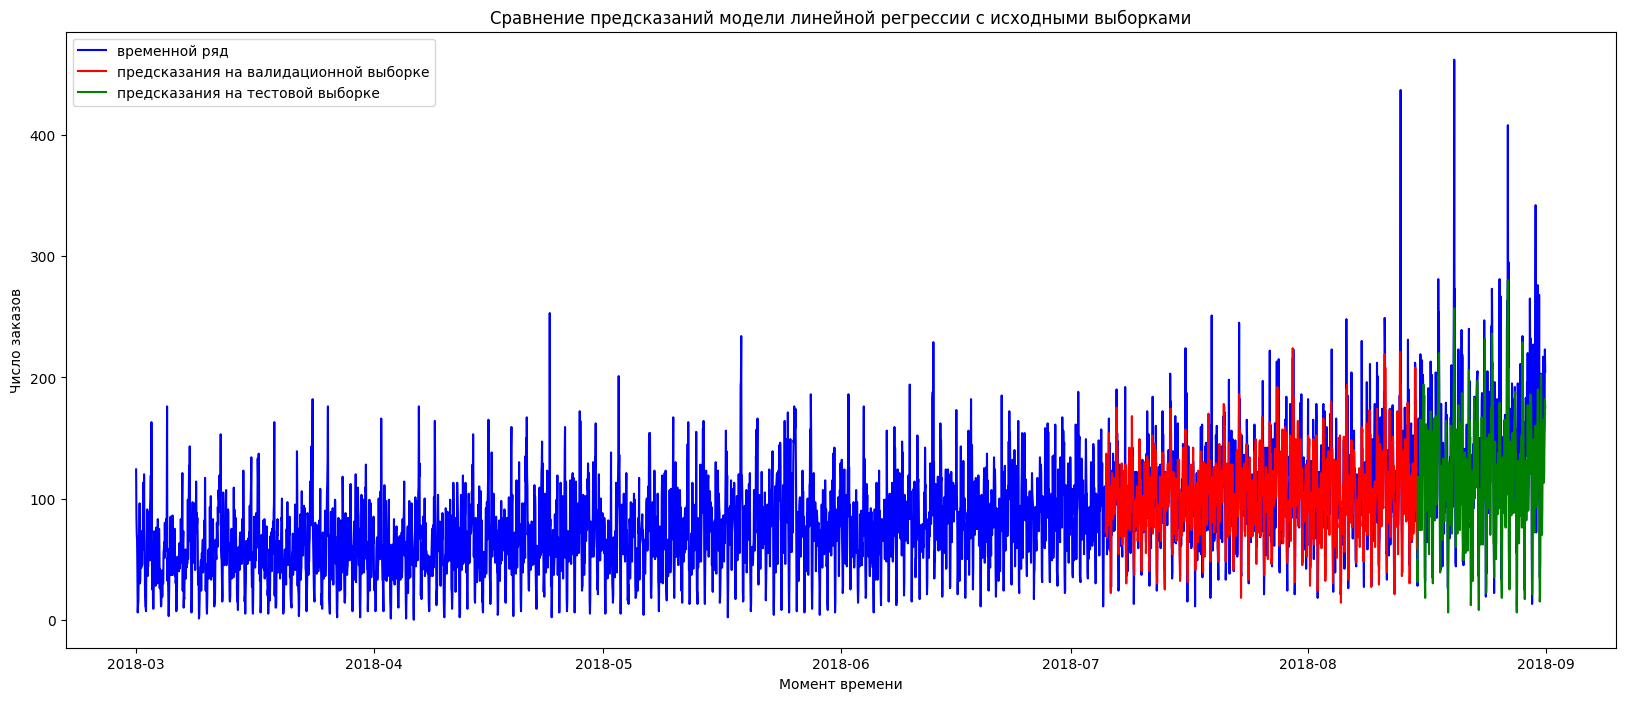

In [46]:
plt.figure(figsize=(20, 8))

# plt.plot(target_train, color='b', label='train')
# plt.plot(target_valid, color='g', label='valid')
# plt.plot(pred_valid, color='r', label='pred_valid')
# plt.plot(target_test, color='m', label='test')
# plt.plot(pred_test, color='c', label='pred_test')

# весь временной ряд
plt.plot(origin_data['num_orders'], color='b', label='временной ряд')

# предсказания модели на валидационной и тестовой выборках
plt.plot(pred_valid, color='r', label='предсказания на валидационной выборке')
plt.plot(pred_test, color='g', label='предсказания на тестовой выборке')

plt.title('Сравнение предсказаний модели линейной регрессии с исходными выборками')
plt.xlabel('Момент времени')
plt.ylabel('Число заказов')

# plt.tight_layout()
plt.legend()
plt.show()

Как видно из графика, предсказания на тестовой выборке (**зелёный**) действительно меньше совпадают с исходным временным рядом (**синий**), чем предсказания на валидационной выборке (**красный**).

### Вывод

Мы проверили модели на тестовых данных. Метрика оказалась меньше, чем на валидационной выборке, но значения **45.59** вполне достаточно. Результаты подтверждены графиком.

## Общий вывод

Мы использовали данные о заказах такси в аэропортах, чтобы компания «Чётенькое такси» могла привлекать больше водителей в период пиковой нагрузки. Для этого мы сделали следующее:
1. Загрузили и обработали данные так, чтобы правильно работать с временным рядом. Построили графики, чтобы рассмотреть колебания числа заказов. 
2. Провели анализ временного ряда, а именно показали скользящее среднее, тренды и сезонность, а также разности. 
3. Сделали всё для обучения моделей (создали "календарные", "отстающие" и "скользящий" признаки; разделили данные на 3 выборки с пропорциями 0.65-0.25-0.1; перебрали гиперпараметры у LinearRegression, LightGBM и CatBoost; оценили время их обучения и качество оценки). Наиболее успешной выбрали линейную регрессию.
4. Проверили лучшую модель на тестовой выборке и получили такое значение метрики RMSE: **45.59**. Вывели график для сравнения временного ряда с предсказаниями.


Таким образом, на **валидационной выборке** у всех моделей метрика была **меньше 31**, а на **тестовых данных** была проверена только **линейная регрессия** (как лучшая). Её ошибка составила **45.59**. \
Несмотря на то, что мы перебрали довольно мало гиперпараметров, нам удалось достичь необходимой точности.